In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
# torch.manual_seed(1)    # reproducible
plt.style.use('dark_background')
%matplotlib inline

import Models as models
import pdb # for debugging
import importlib

torch.cuda.set_device(1)

In [2]:
# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 128
DOWNLOAD_MNIST = True
cudaopt = True

# Network parameteres: filters per layer. More definitions in the Models.py
m1 = 32
m2 = 64
m3 = 512

# Training parameters
LR = 0.002
WD = 1e-5
MN = .9
gamma_sched = .2
step_size_sch = 30
Unfoldings = 6

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# TRAINING DATA
Ntrain = int(60e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
# Defining training function

def train_model(model,train_loader,test_loader,optimizer,scheduler,EPOCH):

    t0 = time.perf_counter()
    tprev = t0

    Loss_train = np.zeros((EPOCH,))
    Loss_test = np.zeros((EPOCH,))
    Acc_test = np.zeros((EPOCH,))
    Acc_train = np.zeros((EPOCH,))
    Time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(max_value=EPOCH-1)
    for epoch in range(EPOCH):
        
        scheduler.step()        
        bar.update(epoch)
        model.train()
        
        correct = 0
        train_loss = 0
        rec_error = 0
        for step, (x, y) in enumerate(train_loader):
            b_x = Variable(x)    
            b_y = Variable(y)               
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()
            
            # computing training stats
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').data.item()
            

        Acc_train[epoch] =  100 * float(correct) / float(len(train_loader.dataset))
        Loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        NNZ = 0.0
        for step, (x, y) in enumerate(test_loader):
            b_x = Variable(x)   
            b_y = Variable(y)               # batch label
            if cudaopt:
                b_y, b_x = b_y.cuda(), b_x.cuda()
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').data.item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()


        Loss_test[epoch] = test_loss/len(test_loader.dataset)
        Acc_test[epoch] =  100 *  float(correct) /float(len(test_loader.dataset))
        Time_test[epoch] = time.perf_counter()-t0
        
        #print('Epoch: ', epoch, '| train loss: ', train_loss.data.cpu().numpy()/len(train_loader.dataset),'| train acc: ', Acc_train[epoch], '%','| test acc: ', Acc_test[epoch], '%')
    
    return model,Acc_train,Acc_test


Training CNN (ML-ISTA with 0 unfolding)

In [4]:

model_0 = models.ML_ISTA_NET(m1,m2,m3,0)
optimizer = torch.optim.SGD(model_0.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_sch,gamma=gamma_sched)

model_0,Acc_train_0,Acc_test_0 = train_model(model_0.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)

100% (99 of 99) |########################| Elapsed Time: 0:09:46 ETA:  00:00:00

Training ML-ISTA

In [5]:

model_mlista = models.ML_ISTA_NET(m1,m2,m3,Unfoldings)
optimizer = torch.optim.SGD(model_mlista.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_sch,gamma=gamma_sched)

model_mlista,Acc_train_mlista,Acc_test_mlista = train_model(model_mlista.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)

100% (99 of 99) |########################| Elapsed Time: 0:58:57 ETA:  00:00:00

Training ML-FISTA

In [6]:
    
model_mlfista = models.ML_FISTA_NET(m1,m2,m3,Unfoldings)
optimizer = torch.optim.SGD(model_mlfista.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_sch,gamma=gamma_sched)

model_mlfista,Acc_train_mlfista,Acc_test_mlfista = train_model(model_mlfista.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)

100% (99 of 99) |########################| Elapsed Time: 0:58:59 ETA:  00:00:00

Training Layered Basis Pursuit

In [7]:
    
model_lbp = models.LBP_NET(m1,m2,m3,Unfoldings)
optimizer = torch.optim.SGD(model_lbp.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_sch,gamma=gamma_sched)

model_lbp,Acc_train_lbp,Acc_test_lbp = train_model(model_lbp.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (99 of 99) |########################| Elapsed Time: 0:43:04 ETA:  00:00:00

Training ML-Learned ISTA

In [8]:
    
model_mllista = models.ML_LISTA_NET(m1,m2,m3,Unfoldings)
optimizer = torch.optim.SGD(model_mllista.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_sch,gamma=gamma_sched)

model_mllista,Acc_train_mllista,Acc_test_mllista = train_model(model_mllista.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (99 of 99) |########################| Elapsed Time: 1:12:44 ETA:  00:00:00

Training *all free* net: similar architecture but with all parameters free to be learned

In [9]:

model_allfree = models.All_Free(m1,m2,m3) # the all_free model has been coded for 6 unfoldings.
optimizer = torch.optim.SGD(model_allfree.parameters(), lr = LR,momentum=MN, weight_decay=WD)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size_sch,gamma=gamma_sched)

model_allfree,Acc_train_allfree,Acc_test_allfree = train_model(model_allfree.cuda(),train_loader,test_loader,optimizer,scheduler,EPOCH)


100% (99 of 99) |########################| Elapsed Time: 0:43:19 ETA:  00:00:00

### Results

Baseline:  98.74 . ML-ISTA:  99.10947368421051 . ML-FISTA:  99.16105263157895 ML-LISTA:  98.80999999999999 . Layered BP:  99.19000000000001 . All Free 98.89000000000001


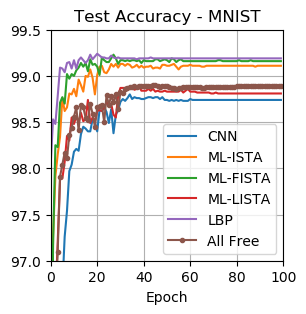

In [11]:
plt.figure(figsize=(3,3))
plt.style.use('default')
plt.plot(Acc_test_0,label= 'CNN')
plt.plot(Acc_test_mlista,label= 'ML-ISTA')
plt.plot(Acc_test_mlfista,label= 'ML-FISTA')
plt.plot(Acc_test_mllista,label= 'ML-LISTA')
plt.plot(Acc_test_lbp,label= 'LBP')
plt.plot(Acc_test_allfree,'.-',label= 'All Free')

plt.title('Test Accuracy - MNIST')
plt.grid()
plt.axis([0,EPOCH,97,99.5])
plt.xlabel('Epoch')
plt.legend()
plt.savefig("MNIST_results.pdf", bbox_inches='tight')

print('Baseline: ', np.mean(Acc_test_0[-20:-1]), '. ML-ISTA: ', np.mean(Acc_test_mlista[-20:-1]), '. ML-FISTA: ', np.mean(Acc_test_mlfista[-20:-1]),'ML-LISTA: ', np.mean(Acc_test_mllista[-20:-1]) ,'. Layered BP: ', np.mean(Acc_test_lbp[-20:-1]),'. All Free', np.mean(Acc_test_allfree[-20:-1]) ) 